<a href="https://www.kaggle.com/code/tousifbnn/oasis-alzheimer-s-detection-cnn?scriptVersionId=236280593" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

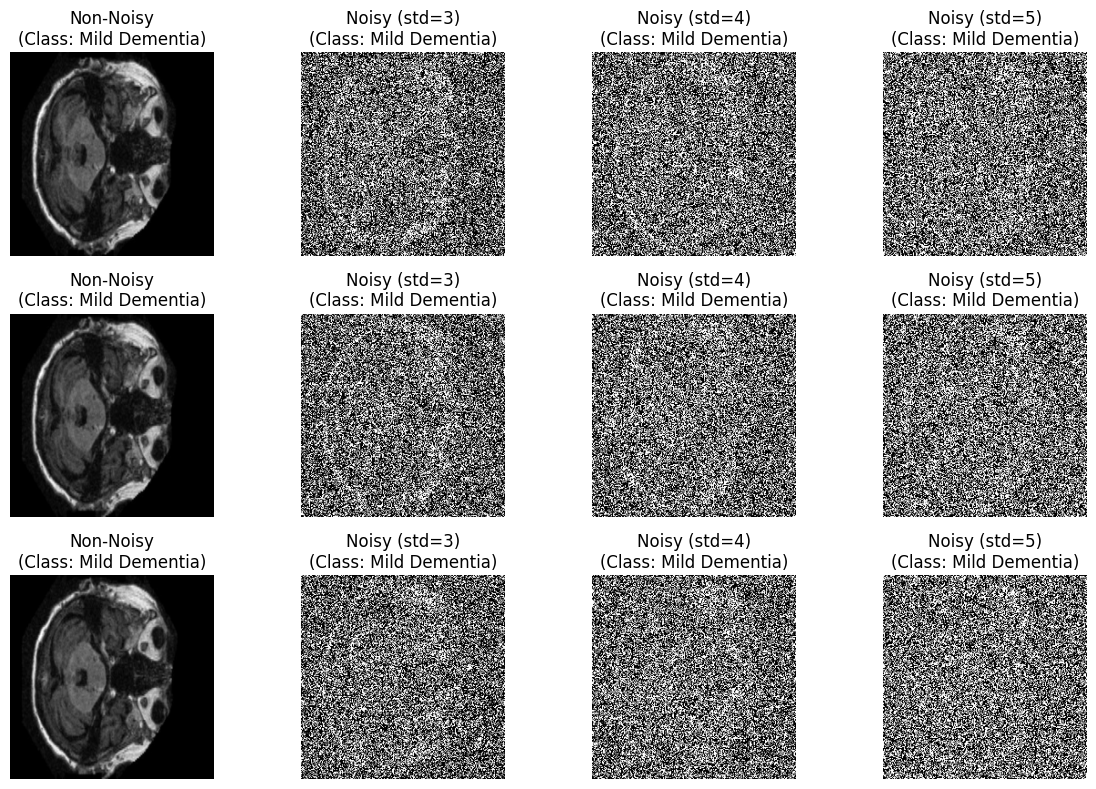

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Ensure matplotlib displays inline (for Jupyter environments)
%matplotlib inline

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Transforms for non-noisy images
transform_non_noisy = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom transform to add Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

# Load dataset without transform initially
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = original_dataset.classes

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(len(class_names))}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

balanced_indices = []
for label in range(len(class_names)):
    selected_indices = indices_per_class[label][:488]
    balanced_indices.extend(selected_indices)

# Define multiple noise levels
noise_levels = [3, 4, 5]
num_samples = 3

# Create subplots: num_samples rows, (1 non-noisy + len(noise_levels)) columns
fig, axes = plt.subplots(num_samples, len(noise_levels) + 1, figsize=(12, 8))

for i in range(num_samples):
    idx = balanced_indices[i]
    img = original_dataset[idx][0]  # PIL Image
    
    # Non-noisy image
    img_non_noisy = transform_non_noisy(img)
    img_non_noisy = img_non_noisy[0].numpy()  # Shape: [1, 224, 224] -> [224, 224]
    img_non_noisy = (img_non_noisy * 0.5) + 0.5  # Denormalize
    img_non_noisy = np.clip(img_non_noisy, 0, 1)  # Ensure values in [0, 1]
    
    # Plot non-noisy image
    axes[i, 0].imshow(img_non_noisy, cmap='gray')
    axes[i, 0].set_title(f'Non-Noisy\n(Class: {class_names[original_dataset[idx][1]]})')
    axes[i, 0].axis('off')
    
    # Noisy images with different std
    for j, std in enumerate(noise_levels):
        transform_noisy = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
            AddGaussianNoise(mean=0.0, std=std)
        ])
        img_noisy = transform_noisy(img)
        img_noisy = img_noisy[0].numpy()
        img_noisy = (img_noisy * 0.5) + 0.5  # Denormalize
        img_noisy = np.clip(img_noisy, 0, 1)
        
        # Plot noisy image
        axes[i, j + 1].imshow(img_noisy, cmap='gray')
        axes[i, j + 1].set_title(f'Noisy (std={std})\n(Class: {class_names[original_dataset[idx][1]]})')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.savefig('noise_level_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Balanced dataset size: 1952


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Epoch [1/10]
Train Loss: 1.3845, Train Accuracy: 35.68%
Epoch [2/10]
Train Loss: 0.9949, Train Accuracy: 59.00%
Val Loss: 1.7290, Val Accuracy: 40.92%
Epoch [3/10]
Train Loss: 0.8426, Train Accuracy: 64.77%
Epoch [4/10]
Train Loss: 0.6566, Train Accuracy: 74.38%
Val Loss: 0.5286, Val Accuracy: 79.28%
Epoch [5/10]
Train Loss: 0.5747, Train Accuracy: 77.64%
Epoch [6/10]
Train Loss: 0.5255, Train Accuracy: 80.53%
Val Loss: 0.4620, Val Accuracy: 81.59%
Epoch [7/10]
Train Loss: 0.4884, Train Accuracy: 81.74%
Epoch [8/10]
Train Loss: 0.4817, Train Accuracy: 81.61%
Val Loss: 0.4202, Val Accuracy: 84.40%
Epoch [9/10]
Train Loss: 0.4980, Train Accuracy: 80.91%
Epoch [10/10]
Train Loss: 0.4747, Train Accuracy: 81.36%
Val Loss: 0.4083, Val Accuracy: 83.63%


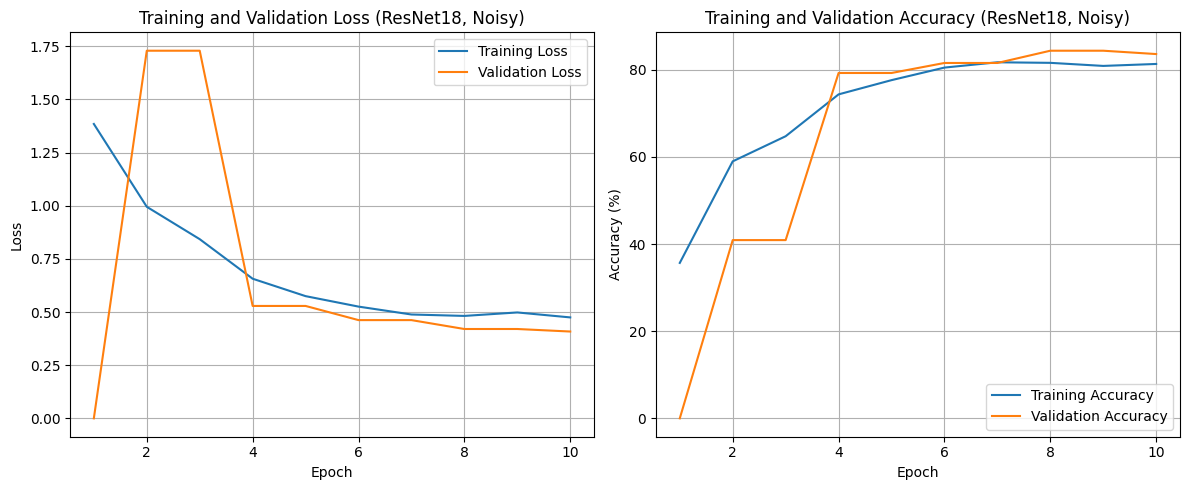

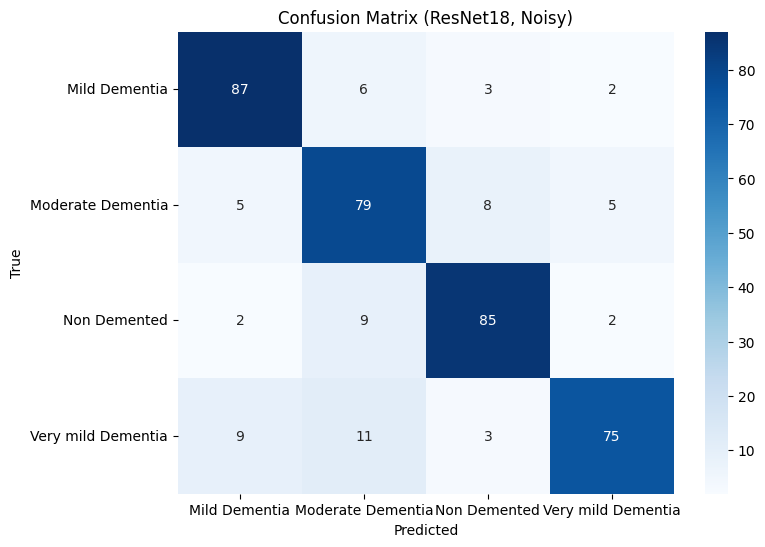


Classification Report (ResNet18, Noisy):
                    precision    recall  f1-score   support

     Mild Dementia       0.84      0.89      0.87        98
 Moderate Dementia       0.75      0.81      0.78        97
      Non Demented       0.86      0.87      0.86        98
Very mild Dementia       0.89      0.77      0.82        98

          accuracy                           0.83       391
         macro avg       0.84      0.83      0.83       391
      weighted avg       0.84      0.83      0.83       391



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Custom transform to add Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=5):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

# Transforms with augmentation and noise for training
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    AddGaussianNoise(mean=0.0, std=5)
])

# Transform for validation (with noise)
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    AddGaussianNoise(mean=0.0, std=5)
])

# Load dataset without transform initially
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Use all 4 classes
num_classes = len(class_names)
print("Classes:", class_names)
assert num_classes == 4, f"Expected 4 classes, got {num_classes}"

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(num_classes)}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

# Take 488 samples per class
balanced_indices = []
balanced_labels = []
for label in range(num_classes):
    selected_indices = indices_per_class[label][:488]
    balanced_indices.extend(selected_indices)
    balanced_labels.extend([label] * len(selected_indices))

print("Balanced dataset size:", len(balanced_indices))

# Split dataset
train_idx, val_idx = train_test_split(
    list(range(len(balanced_indices))),
    test_size=0.2, stratify=balanced_labels, random_state=42
)

train_indices = [balanced_indices[i] for i in train_idx]
val_indices = [balanced_indices[i] for i in val_idx]

# Create datasets with appropriate transforms
train_dataset = torch.utils.data.Subset(original_dataset, train_indices)
val_dataset = torch.utils.data.Subset(original_dataset, val_indices)

# Apply transforms
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

# Data loaders
batch_size = 32
num_workers = 4
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    else:
        val_losses.append(val_losses[-1] if val_losses else 0)
        val_accuracies.append(val_accuracies[-1] if val_accuracies else 0)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    if (epoch + 1) % 2 == 0:
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet18, Noisy)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (ResNet18, Noisy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_resnet18_4classes_noisy.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix and class-wise metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ResNet18, Noisy)')
plt.savefig('confusion_matrix_resnet18_4classes_noisy.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics
print("\nClassification Report (ResNet18, Noisy):")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Save model
torch.save(model.state_dict(), 'resnet18_alzheimer_4classes_noisy.pth')